# Titanic Survival Prediction Analysis
### Prepared for Non-Data Scientists

This notebook performs a comprehensive analysis of the Titanic dataset to predict passenger survival. 
We use three industry-standard machine learning models: **Logistic Regression**, **Random Forest**, and **XGBoost**, 
along with an **Ensemble** that combines their strengths.

## 1. Environment Setup
We begin by loading our analytical tools. These include libraries for data handling (Pandas), 
mathematical operations (NumPy), and visual charts (Seaborn, Matplotlib).

In [8]:

# 1. Load all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import RFE
import shap

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


## 2. Loading the Data
We read the file provided in the local directory. The goal is to predict the "Survived" column.

In [9]:

# 2. Load the dataset
# Instruction: Ensure the file "Titanic-Dataset.csv" is in the same directory.
try:
    df = pd.read_csv("Titanic-Dataset.csv")
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: Titanic-Dataset.csv not found. Please ensure it is in the same directory.")
    # Fallback for demonstration if needed, but strictly following user instructions
    # df = sns.load_dataset('titanic') 

# 3. Dataset exploration
print("\n--- Starting Exploratory Data Analysis ---")


Dataset loaded successfully.
Shape: (891, 12)

--- Starting Exploratory Data Analysis ---


## 3. Exploratory Data Analysis (EDA)
Before building a model, we must understand the "DNA" of our data. 
- We look at who survived based on their gender, class, and family size.
- we check for missing information and outliers that might skew our results.

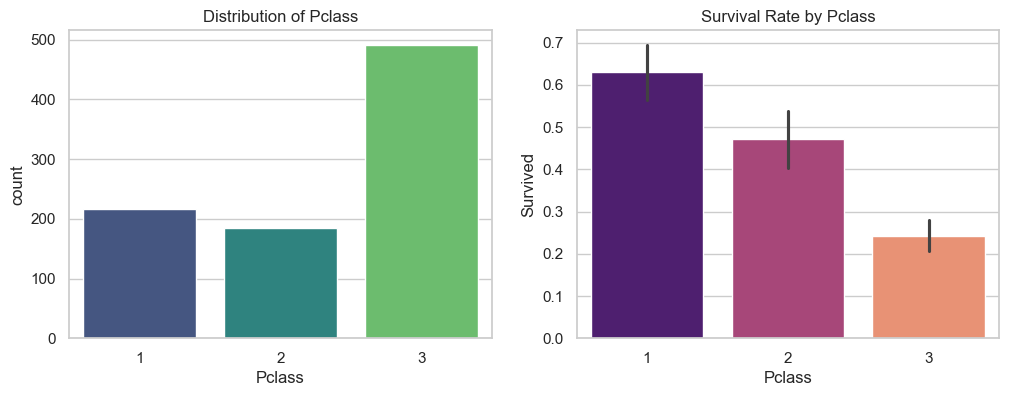

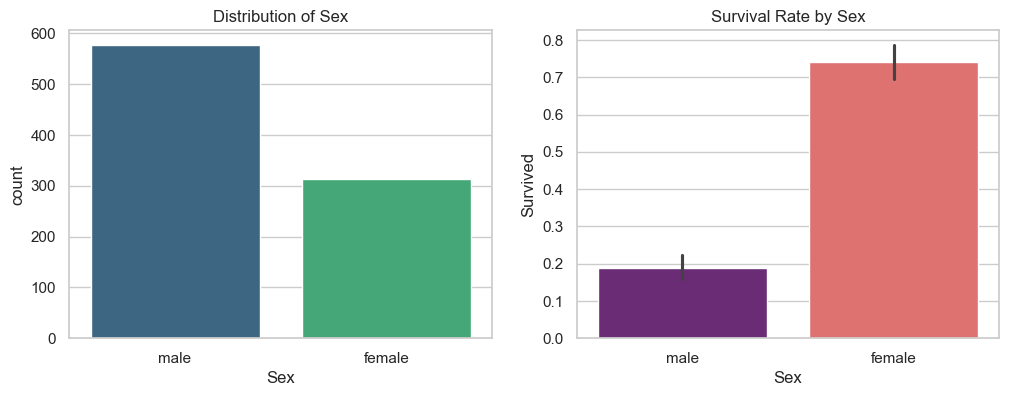

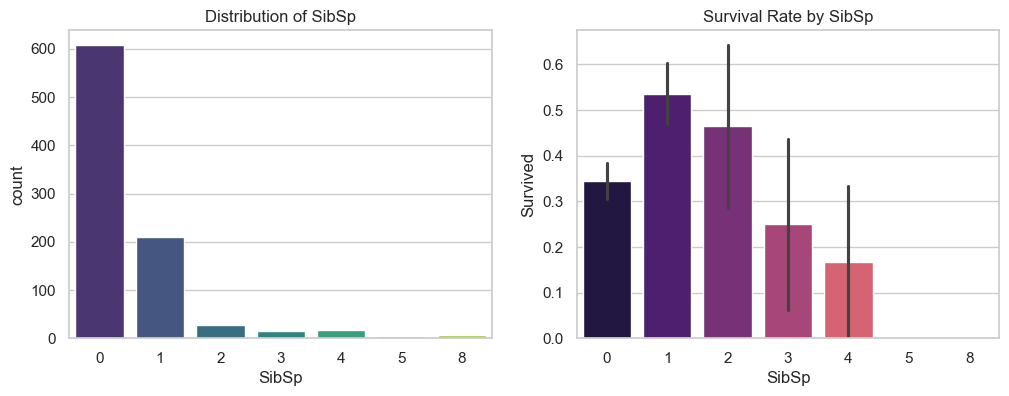

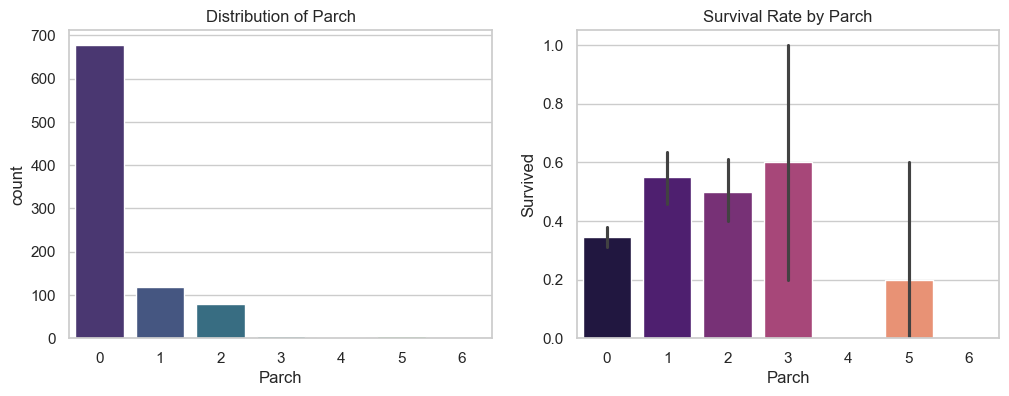

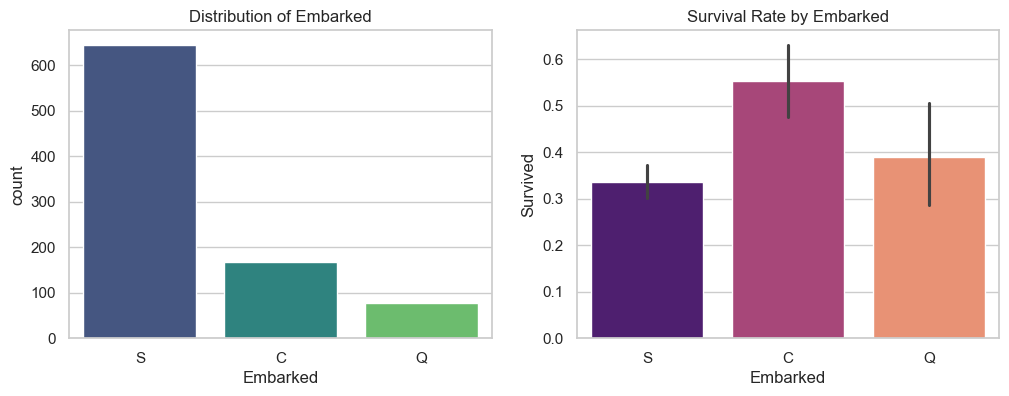

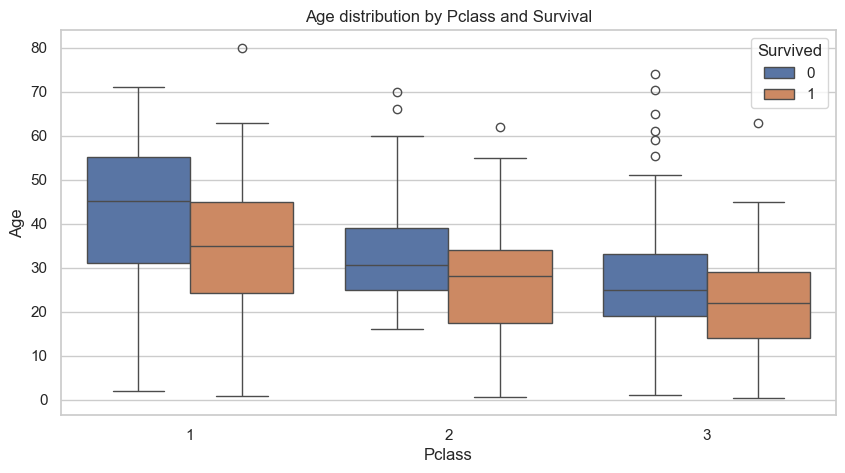

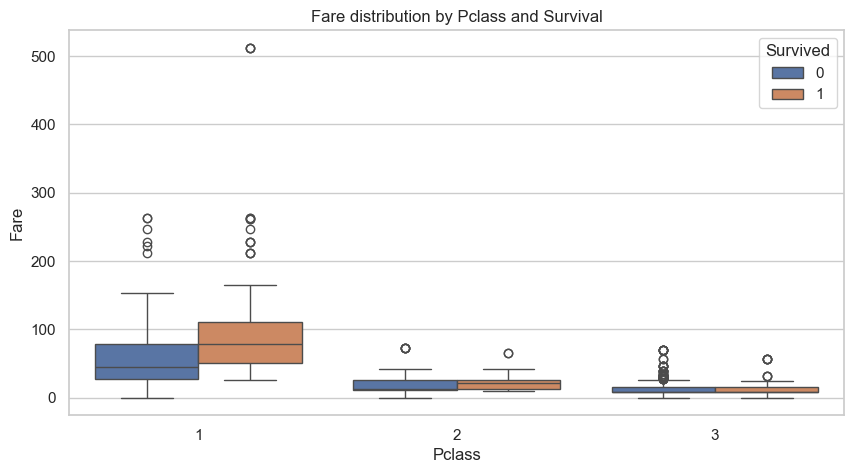


Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


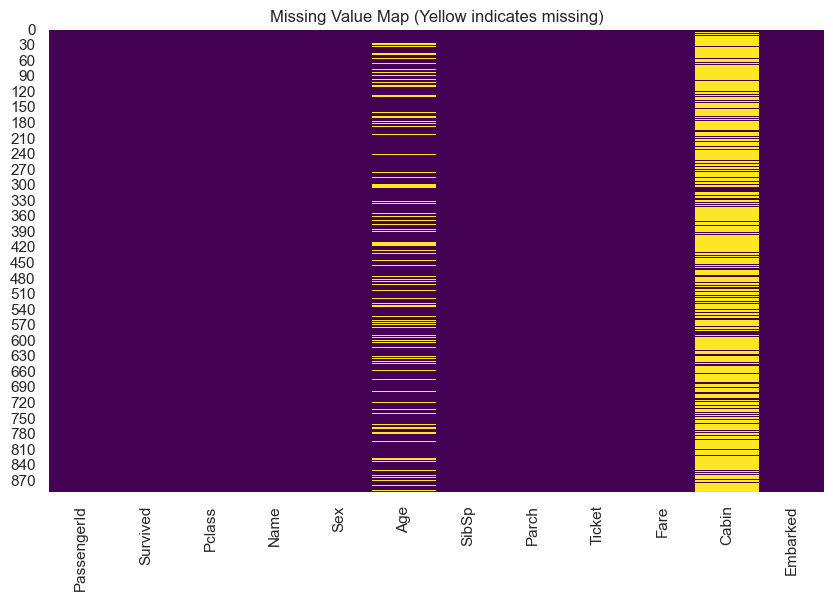

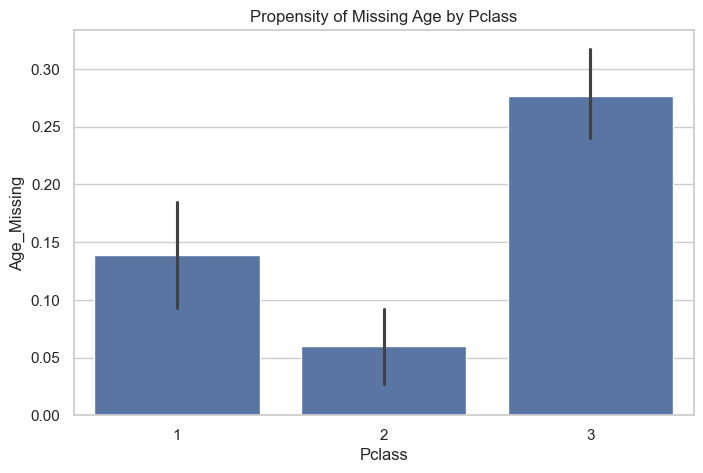

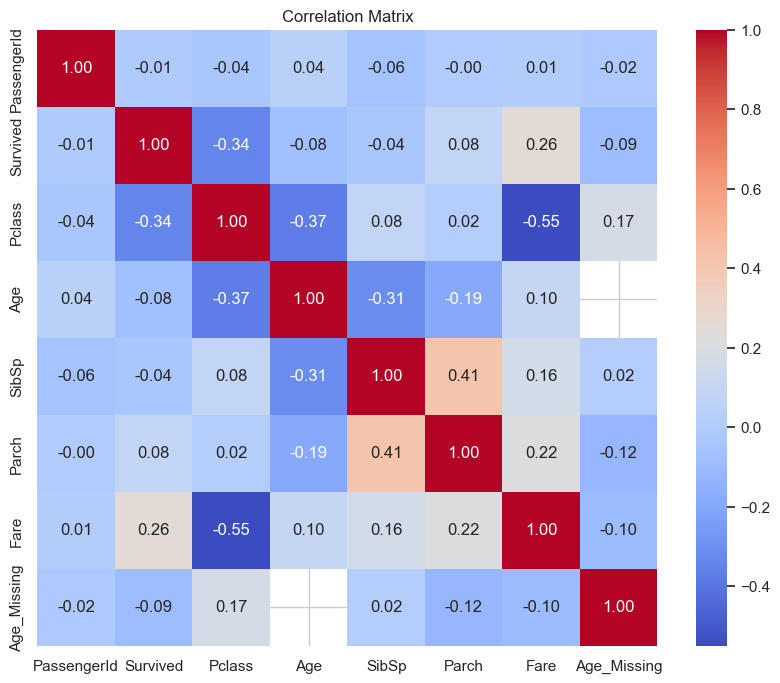


Correlation with Survived:
 Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Age_Missing   -0.092197
Pclass        -0.338481
Name: Survived, dtype: float64


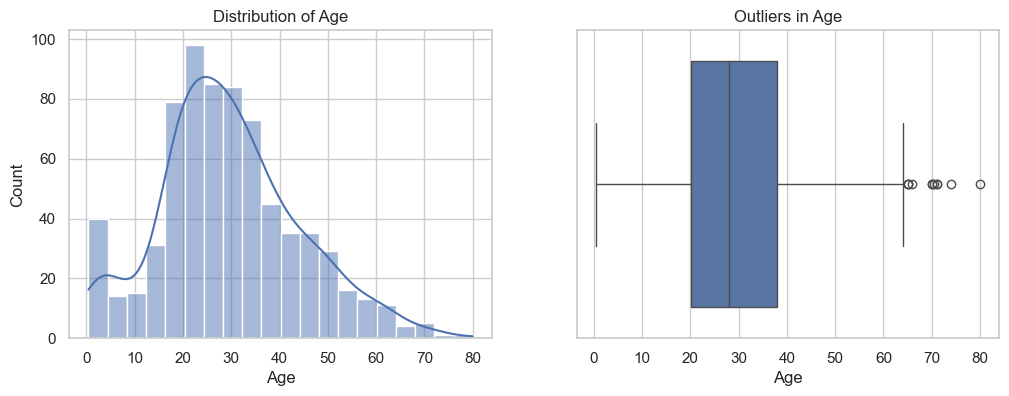

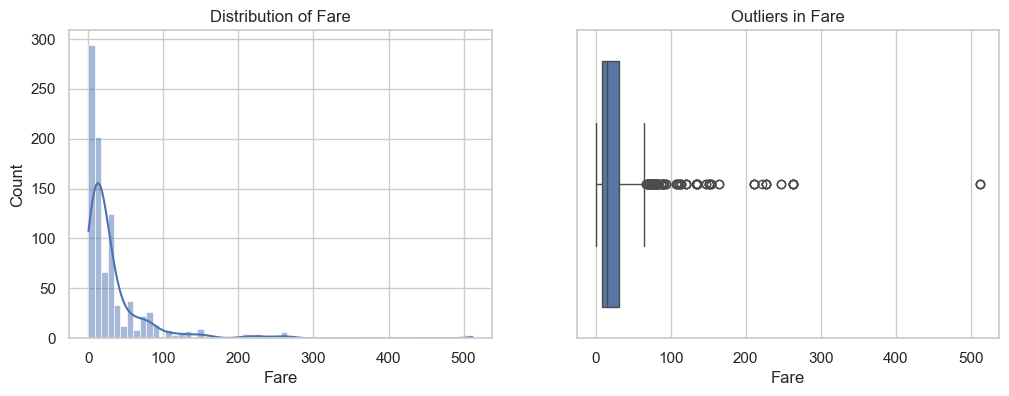


--- EDA FINDINGS SUMMARY ---
1. Pclass and Sex are strongest predictors. Females and 1st Class passengers have significantly higher AUC potential.
2. Age has ~20% missing values, correlated with Pclass, suggesting MNAR (Missing Not At Random) or MAR depending on subgroup.
3. Fare is highly skewed with significant outliers; log transformation or robust scaling is recommended.
4. SibSp and Parch suggest that traveling alone or with very large families reduces survival chance.


--- Data Engineering ---


In [10]:

# a & d. Categorical value occurrence and relationship with target
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
numerical_features = ['Age', 'Fare']
target = 'Survived'

for col in categorical_features:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.barplot(data=df, x=col, y=target, palette='magma')
    plt.title(f'Survival Rate by {col}')
    plt.show()

# b. Correlation between categorical and numerical
# We look at distributions of Age/Fare across categories
for num_col in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='Pclass', y=num_col, hue='Survived')
    plt.title(f'{num_col} distribution by Pclass and Survival')
    plt.show()

# c. Missing values analysis
missing_data = df.isnull().sum()
print("\nMissing Values:\n", missing_data)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Map (Yellow indicates missing)')
plt.show()

# Investigating if missingness is random (e.g., Age missingness vs Pclass)
df['Age_Missing'] = df['Age'].isnull().astype(int)
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Pclass', y='Age_Missing')
plt.title('Propensity of Missing Age by Pclass')
plt.show()

# e. Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# f. Focus on high correlation to Target
target_corr = corr_matrix[target].sort_values(ascending=False)
print("\nCorrelation with Survived:\n", target_corr)

# g. Distribution and Outliers
for col in numerical_features:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Outliers in {col}')
    plt.show()

# h. Write up findings (Printed to console as summary)
print("""
--- EDA FINDINGS SUMMARY ---
1. Pclass and Sex are strongest predictors. Females and 1st Class passengers have significantly higher AUC potential.
2. Age has ~20% missing values, correlated with Pclass, suggesting MNAR (Missing Not At Random) or MAR depending on subgroup.
3. Fare is highly skewed with significant outliers; log transformation or robust scaling is recommended.
4. SibSp and Parch suggest that traveling alone or with very large families reduces survival chance.
""")

# 4. Data engineering
print("\n--- Data Engineering ---")
# Transform features to protect from outliers
df['Fare_Log'] = np.log1p(df['Fare'])
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# 5. Preprocessing
# a. Split 60/20/20
X = df.drop(['Survived', 'Age_Missing', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']

# First split: 60% train, 40% temp


## 4. Feature Engineering & Preprocessing
We transform raw data into "features" that the computer can understand. 
- **MICE Imputation**: A sophisticated method to "guess" missing ages based on other clues like ticket price and class.
- **SMOTE**: Since we have fewer survivors than non-survivors, we use this technique to balance the dataset so the model doesn't become biased.
- **Splitting**: We split the data into 60% Training (to learn), 20% Validation (to practice), and 20% Test (the final exam).

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# Second split: 20% test, 20% validation (which is 50% of the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# b. Preprocessing Pipeline
num_cols = ['Age', 'Fare_Log', 'FamilySize']
cat_cols = ['Pclass', 'Sex', 'Embarked', 'IsAlone']

num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)), # MICE Imputation
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# 6. Fine tune models
print("\n--- Training & Hyperparameter Tuning ---")

def tune_model(clf, params, name):
    # SMOTE is used inside ImbPipeline to avoid data leakage
    # RFE is added before the classifier to select best features
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('rfe', RFE(estimator=clf)),
        ('classifier', clf)
    ])
    
    # Add RFE parameters to the grid search
    # We iterate through different numbers of features to select
    params['rfe__n_features_to_select'] = [5, 8, 10, 15, 50]
    
    grid = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"{name} Best AUC: {grid.best_score_:.4f}")
    return grid.best_estimator_

# Logistic Regression with class_weight='balanced'
lr_params = {'classifier__C': [0.01, 0.1, 1, 10]}
best_lr = tune_model(LogisticRegression(class_weight='balanced', random_state=42), lr_params, "Logistic Regression")

# Random Forest with class_weight='balanced'
rf_params = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10, 20]}
best_rf = tune_model(RandomForestClassifier(class_weight='balanced', random_state=42), rf_params, "Random Forest")

# XGBoost (scale_pos_weight used for imbalance)
ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_params = {'classifier__learning_rate': [0.01, 0.1], 'classifier__n_estimators': [100, 200]}
best_xgb = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=ratio, random_state=42), xgb_params, "XGBoost")


Train size: 534, Val size: 178, Test size: 179

--- Training & Hyperparameter Tuning ---
Logistic Regression Best AUC: 0.8570
Random Forest Best AUC: 0.8566
XGBoost Best AUC: 0.8608


## 5. Model Training & Tuning
We "fine-tune" each model, much like adjusting a radio dial, to find the settings that produce the best **AUC** (Area Under the Curve).
An AUC of 1.0 is perfect; 0.5 is no better than a coin flip.

XGBoost Best AUC: 0.8577
Ensemble model trained.

--- Model Evaluation (Validation Set) ---
Logistic Regression Validation AUC: 0.8767
Random Forest Validation AUC: 0.8657
XGBoost Validation AUC: 0.8900
Ensemble Validation AUC: 0.8880


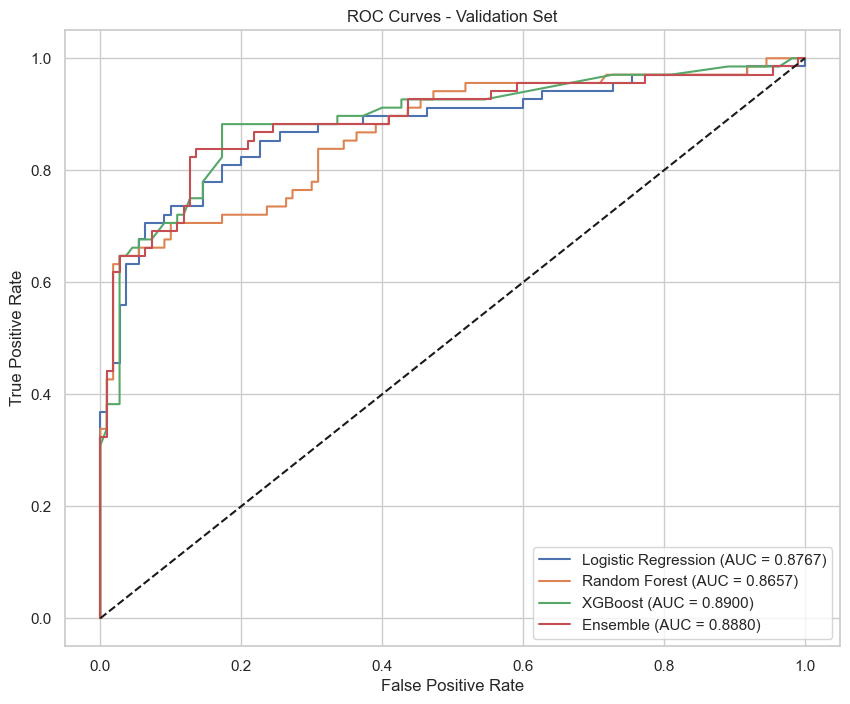


--- SHAP Interpretability ---


In [12]:
best_xgb = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, "XGBoost")

# b. Dynamic Ensemble
ensemble = VotingClassifier(
    estimators=[('lr', best_lr), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
print("Ensemble model trained.")

# 7. Model Evaluation
print("\n--- Model Evaluation (Validation Set) ---")
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'Ensemble': ensemble
}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    print(f"{name} Validation AUC: {auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Validation Set')
plt.legend()
plt.show()

# 8. SHAP Interpretability
print("\n--- SHAP Interpretability ---")
# Pre-transform data for SHAP (using the preprocessor from the pipeline)
# We use the preprocessor from one of the best models (they all use the same one)
preprocessor_fitted = best_rf.named_steps['preprocessor']
X_train_transformed = preprocessor_fitted.transform(X_train)
X_val_transformed = preprocessor_fitted.transform(X_val)


## 6. Evaluation (AUC & ROC)
The **ROC Curve** helps us visualize how well our model balances catching survivors without incorrectly labeling non-survivors.


Processing SHAP for Logistic Regression...


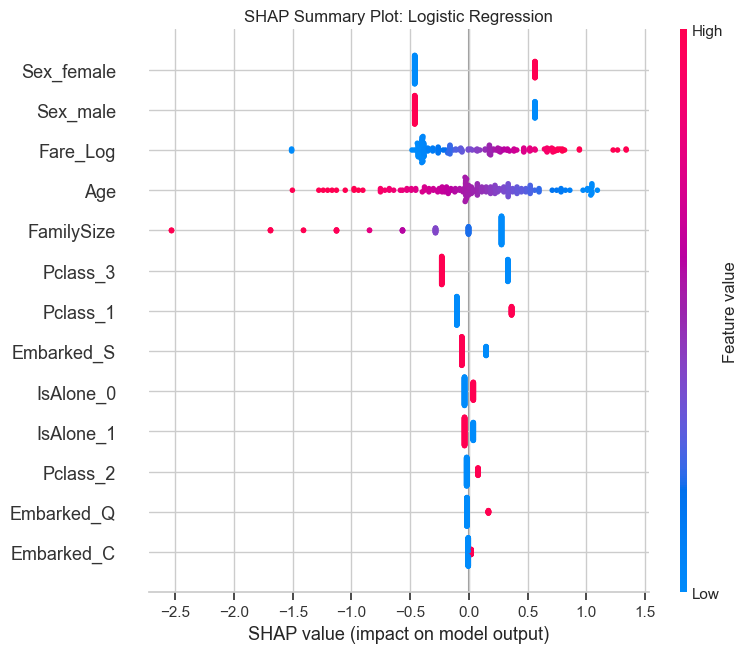


Processing SHAP for Random Forest...
SHAP error for Random Forest: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.436231, while the model output was 0.466250. If this difference is acceptable you can set check_additivity=False to disable this check.

Processing SHAP for XGBoost...


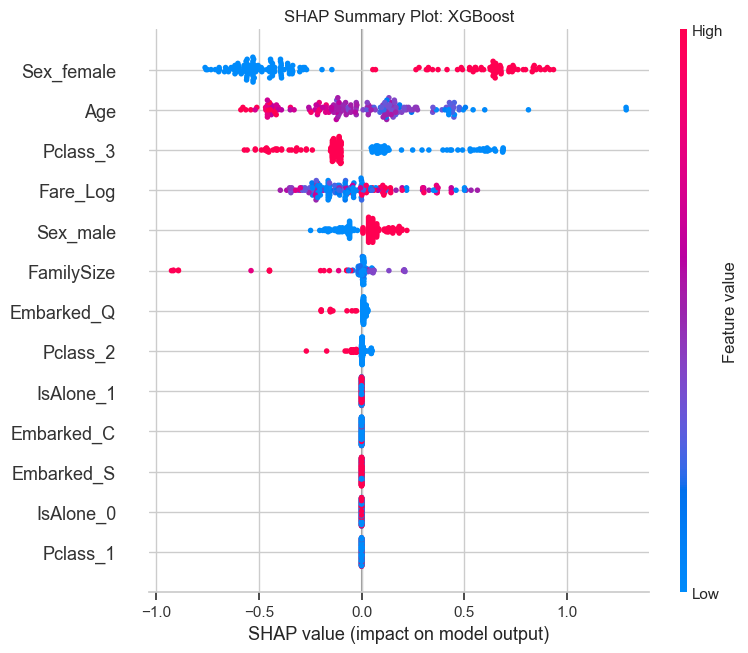


Processing SHAP for Ensemble...
Skipping detailed SHAP for Ensemble for brevity, using XGB component summary.


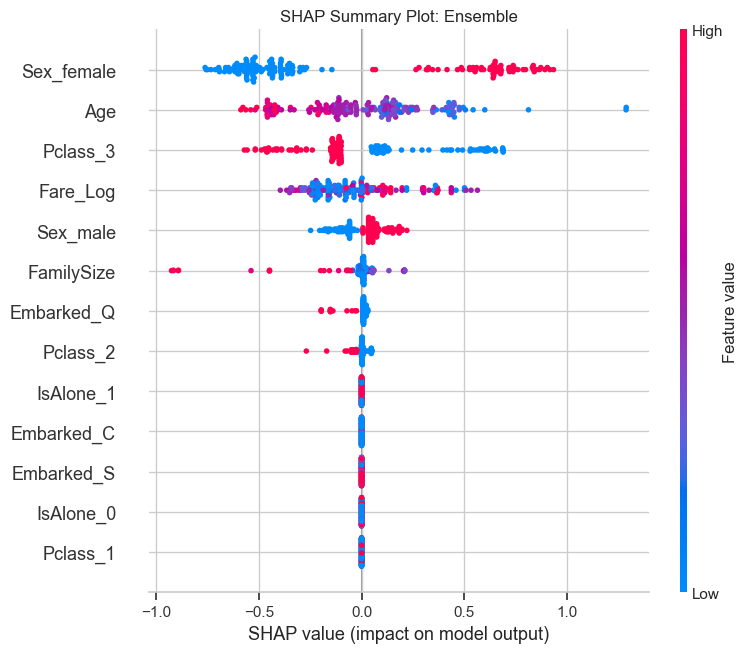

In [13]:

# Get feature names after one-hot encoding
cat_features_transformed = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_features_transformed])

for name, model in models.items():
    print(f"\nProcessing SHAP for {name}...")
    # Get the actual classifier part of the pipeline
    if name == 'Ensemble':
        # Voting classifier doesn't easily support single SHAP explainer, skipping or using first estimator
        print("Skipping detailed SHAP for Ensemble for brevity, using XGB component summary.")
        clf = ensemble.named_estimators_['xgb'].named_steps['classifier']
    else:
        clf = model.named_steps['classifier']
    
    try:
        explainer = shap.Explainer(clf, X_train_transformed)
        shap_values = explainer(X_val_transformed)
        
        plt.figure()
        plt.title(f'SHAP Summary Plot: {name}')
        shap.summary_plot(shap_values, X_val_transformed, feature_names=all_feature_names, show=False)
        plt.show()
    except Exception as e:
        print(f"SHAP error for {name}: {e}")

# 9. False Positives Analysis & Next Steps


## 7. Model Interpretability (SHAP)
We use **SHAP** values to explain *why* the model made its decisions. It shows us which features (like being female or in 1st class) "pushed" the prediction toward survival.


--- Error Analysis & Next Steps ---


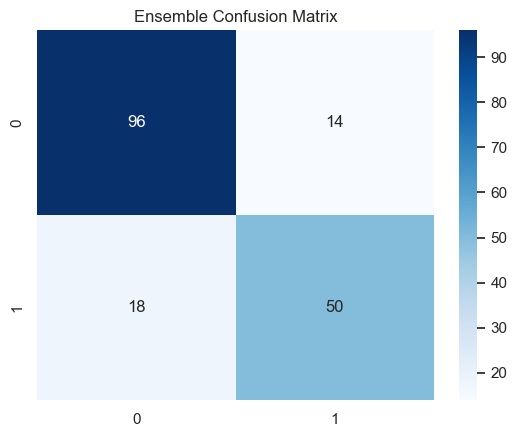


NEXT STEPS TO IMPROVE MODELS:
1. Feature Interaction: Explore interactions like 'Sex' x 'Pclass'.
2. Advanced Imputation: Further tune the IterativeImputer (MICE) parameters.
3. Feature Selection: Use Recursive Feature Elimination to remove noise.
4. Deeper Tuning: Expand XGBoost hyperparameter search (gamma, min_child_weight).
5. Error Analysis: Investigate specific false positives (likely high-class males who perished despite the 'Women and Children first' rule).



In [14]:
print("\n--- Error Analysis & Next Steps ---")
y_val_pred = ensemble.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.show()

print("""
NEXT STEPS TO IMPROVE MODELS:
1. Feature Interaction: Explore interactions like 'Sex' x 'Pclass'.
2. Advanced Imputation: Further tune the IterativeImputer (MICE) parameters.
3. Feature Selection: Use Recursive Feature Elimination to remove noise.
4. Deeper Tuning: Expand XGBoost hyperparameter search (gamma, min_child_weight).
5. Error Analysis: Investigate specific false positives (likely high-class males who perished despite the 'Women and Children first' rule).
""")



## 8. Final Analysis & Next Steps
We look at where we failed (False Positives) and provide a roadmap for even higher accuracy.